In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


**Data Preparation**

In [3]:
df = pd.read_csv('/content/btc.csv')

In [4]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


As shown in the above data frame, the column Close represents the closing price of bitcoins. We need only the column Close to make predictions, so we take that particular column alone as follows:

In [5]:
data = df['Close'].values



Next, we standardize the data and bring it to the same scale,




     


In [6]:
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))




Plot and observe the trend of how the bitcoins price changes as follows, Since we scaled the price, it is not a bigger number:


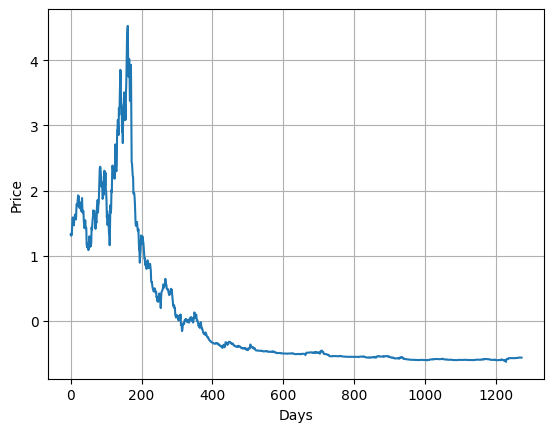

In [7]:


plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()






We define a function called get_data which generates the input and output. It takes the data and window_size as an input and generates the input and target column.

What is window size? We move the x values window_size times ahead and get the y values. For instance, as shown in the below table with window_size = 1, Y values are just 1-time step ahead of x values.

The get_data() function is defined as follows:





     


In [8]:
def get_data(data, window_size):
    X = []
    y = []

    i = 0

    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y

In [9]:
X, y = get_data(data, window_size = 7)



Consider the first 1000 points as a train set and the rest of the points in the dataset as the test set:


In [10]:


#train set
X_train  = np.array(X[:1000])
y_train = np.array(y[:1000])

#test set
X_test = np.array(X[1000:])
y_test = np.array(y[1000:])






In [11]:
X_train.shape

(1000, 7, 1)



    1000 implies the number of data points (sample_size)

    7 specifies the window size (time_steps)

    1 specifies the dimension of our dataset (features)



Defining Network Parameters

Define the network parameters:





     


In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
batch_size = 7
window_size = 7
hidden_layer = 256
learning_rate = 0.001

Define the placeholders for our input and output:





     


In [16]:
input = tf.placeholder(tf.float32, [batch_size, window_size, 1])
target = tf.placeholder(tf.float32, [batch_size, 1])


Defining weights

Let's define all the weights we use in our LSTM cell.

Weights of the input gate:




     


In [17]:
U_i = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_i = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_i = tf.Variable(tf.zeros([hidden_layer]))




Weights of the forget gate:





     


In [18]:
U_f = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_f = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_f = tf.Variable(tf.zeros([hidden_layer]))



Weights of the output gate:




     


In [19]:
U_o = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_o = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_o = tf.Variable(tf.zeros([hidden_layer]))




Weights of the candidate state:





     


In [20]:
U_g = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_g = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_g = tf.Variable(tf.zeros([hidden_layer]))



Output layer weight:





     


In [21]:
V = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
b_v = tf.Variable(tf.zeros([1]))

## 🧠 Define the LSTM Cell

We define the function called `LSTM_cell`, which returns the cell state and hidden state as an output. Recall the steps we saw in the forward propagation of LSTM:

$$
i_t = \sigma(U_i x_t + W_i h_{t-1} + b_i)
$$

$$
f_t = \sigma(U_f x_t + W_f h_{t-1} + b_f)
$$

$$
o_t = \sigma(U_o x_t + W_o h_{t-1} + b_o)
$$

$$
g_t = \tanh(U_g x_t + W_g h_{t-1} + b_g)
$$

$$
c_t = f_t \cdot c_{t-1} + i_t \cdot g_t
$$

$$
h_t = o_t \cdot \tanh(c_t)
$$

The `LSTM_cell` is implemented as shown in the following code. It takes the input, previous hidden state, and previous cell state as inputs, and returns the current cell state and current hidden state.


In [22]:
def LSTM_cell(input, prev_hidden_state, prev_cell_state):


    it = tf.sigmoid(tf.matmul(input, U_i) + tf.matmul(prev_hidden_state, W_i) + b_i)

    ft = tf.sigmoid(tf.matmul(input, U_f) + tf.matmul(prev_hidden_state, W_f) + b_f)

    ot = tf.sigmoid(tf.matmul(input, U_o) + tf.matmul(prev_hidden_state, W_o) + b_o)

    gt = tf.tanh(tf.matmul(input, U_g) + tf.matmul(prev_hidden_state, W_g) + b_g)

    ct = (prev_cell_state * ft) + (it * gt)

    ht = ot * tf.tanh(ct)

    return ct, ht

**Defining forward propagation**

In [23]:


#initialize the list called y_hat for storing the predicted output
y_hat = []

#for each batch we compute the output and store it in the y_hat list
for i in range(batch_size):

    #initialize hidden state and cell state for each batch
    hidden_state = np.zeros([1, hidden_layer], dtype=np.float32)
    cell_state = np.zeros([1, hidden_layer], dtype=np.float32)


    #compute the hidden state and cell state of the LSTM cell for each time step
    for t in range(window_size):
        cell_state, hidden_state = LSTM_cell(tf.reshape(input[i][t], (-1, 1)), hidden_state, cell_state)

    #compute y_hat and append it to y_hat list
    y_hat.append(tf.matmul(hidden_state, V) + b_v)






Defining backpropagation

After performing forward propagation and predicting the output, we compute the loss. We use mean squared error as our loss function and the total loss is the sum of losses across all the time steps as follows:

In [24]:


losses = []

for i in range(len(y_hat)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(target[i], (-1, 1)), y_hat[i]))

loss = tf.reduce_mean(losses)








To avoid the exploding gradient problem, we perform gradient clipping:





     


In [25]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

We use Adam optimizer and minimize our loss function:


In [26]:



optimizer = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(gradients, tf.trainable_variables()))








**Training the LSTM model**

Start the TensorFlow session and initialize all the variables:


In [27]:


session = tf.Session()
session.run(tf.global_variables_initializer())






In [28]:


epochs = 100






In [30]:
for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []

    #Sample some batche of data and train the network
    while(index + batch_size) <= len(X_train):

        #sample batch of data
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]

        #predict the prices and compute loss
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={input:X_batch, target:y_batch})

        #store the loss
        epoch_loss.append(loss_val)

        #store the predictions
        train_predictions.append(predicted)
        index += batch_size


for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []

    #Sample some batche of data and train the network
    while(index + batch_size) <= len(X_train):

        #sample batch of data
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]

        #predict the prices and compute loss
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={input:X_batch, target:y_batch})

        #store the loss
        epoch_loss.append(loss_val)

        #store the predictions
        train_predictions.append(predicted)
        index += batch_size


    #print the loss on every 10 iterations
    if (i % 10)== 0:
        print('Epoch {}, Loss: {} '.format(i,np.mean(epoch_loss)))

Epoch 0, Loss: 0.007589710410684347 
Epoch 10, Loss: 0.007278479170054197 
Epoch 20, Loss: 0.00726109417155385 
Epoch 30, Loss: 0.006898877210915089 
Epoch 40, Loss: 0.006228229496628046 
Epoch 50, Loss: 0.007226845715194941 
Epoch 60, Loss: 0.006234420463442802 
Epoch 70, Loss: 0.006066355388611555 
Epoch 80, Loss: 0.005823134444653988 
Epoch 90, Loss: 0.0062060244381427765 



Making predictions using the LSTM model

Now, we will start making predictions on the test set.


In [32]:


predicted_output = []
i = 0
predicted_output = []
i = 0
while i+batch_size <= len(X_test):

    output = session.run([y_hat],feed_dict={input:X_test[i:i+batch_size]})
    i += batch_size
    predicted_output.append(output)

In [33]:
predicted_output[0]

[[array([[-0.6050487]], dtype=float32),
  array([[-0.6012745]], dtype=float32),
  array([[-0.6006067]], dtype=float32),
  array([[-0.5999578]], dtype=float32),
  array([[-0.5992776]], dtype=float32),
  array([[-0.6014522]], dtype=float32),
  array([[-0.59684926]], dtype=float32)]]

 the predicted values are in a nested list. So we will just flatten them.

In [34]:
predicted_values_test = []
for i in range(len(predicted_output)):
  for j in range(len(predicted_output[i][0])):
    predicted_values_test.append(predicted_output[i][0][j])


In [35]:
predicted_values_test[0]

array([[-0.6050487]], dtype=float32)



As we took the first 1000 points as a training set, we make predictions for time step greater than 1000.


In [39]:


predictions = []
for i in range(1280):
      if i >= 1000:
        predictions.append(predicted_values_test[i-1019])
      else:
        predictions.append(None)






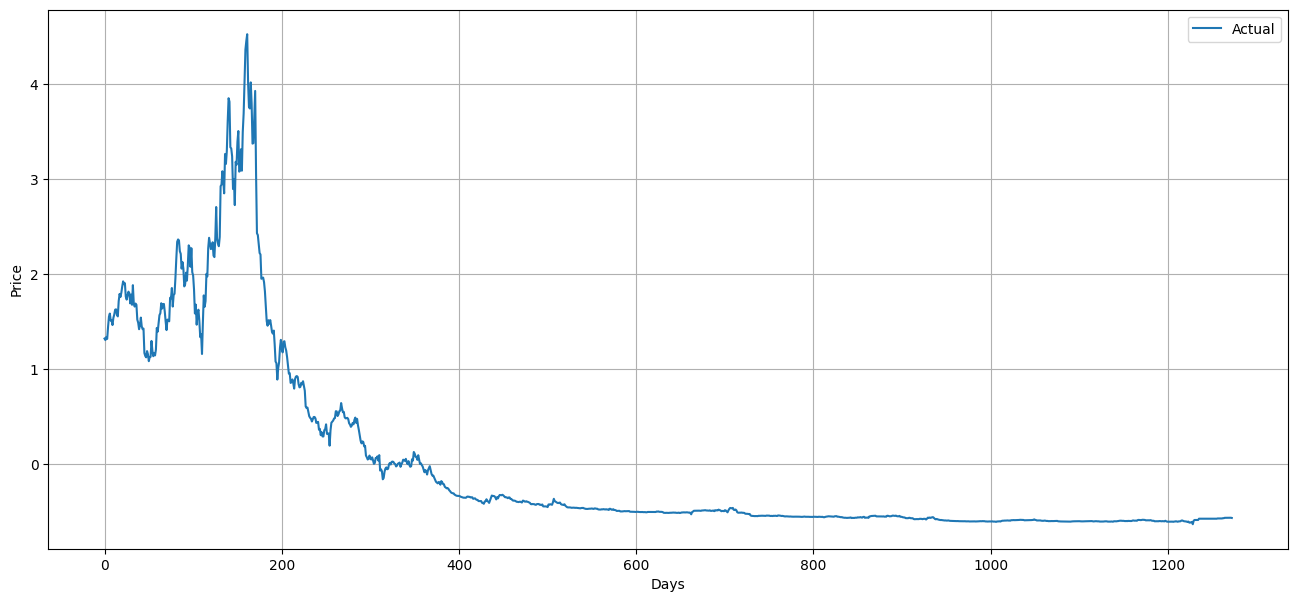

In [46]:

plt.figure(figsize=(16, 7))
plt.plot(data, label='Actual')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()
plt.show()
